## Set GPU

In [1]:
import torch
if torch.cuda.is_available():
    device = 'cuda'
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    device = 'cpu'
print(f'{device=}')

Tesla T4
device='cuda'


## Imports

In [2]:
import numpy as np
import h5py as h5
from gwpy.timeseries import TimeSeries
import pandas as pd
from pathlib import Path
from gwpy.timeseries import TimeSeriesDict
#from lalframe.utils.frtools import get_channels
from os import listdir
from gwpy.signal import filter_design
from matplotlib import pyplot as plt
from matplotlib import gridspec
from tqdm import tqdm
import time
import json
import os
import ERF
import math
import multiprocessing
import gwpy

In [3]:
import numpy as np
import torch
from gwpy.signal.qtransform import QTile as gwpy_QTile
from scipy.interpolate import InterpolatedUnivariateSpline
from torch_spline_interpolation_beta import *
#from qtransform_beta import *

In [4]:
import importlib
import sys
from qtransform_beta import *

# Reload the module
importlib.reload(sys.modules['qtransform_beta'])

<module 'qtransform_beta' from '/home/jovyan/qtransform_beta.py'>

## Load data

In this example we load 1 4s long timeseries form LIGO open data and construct an array of timeseries repeating the original time series num_rows times.

the array is both in numpy and torch format respetively for gwpy and custom torch qtransform

In [5]:
sample_rate = 500.0
duration = 6

gps = 1239082262
data = TimeSeries.fetch_open_data('H1', gps-8, gps+8)
data = data.resample(sample_rate)
data = data.whiten()
event = data.crop(gps-duration/2, gps+duration/2)
print(event)

TimeSeries([ 2.55090438,  0.4074086 ,  1.32679891, ...,
             1.13031862,  4.55195388, -0.63746075]
           unit: dimensionless,
           t0: 1239082258.998 s,
           dt: 0.002 s,
           name: Strain,
           channel: None)


In [6]:
num_rows=2

# Extract values from the event
event_values = event.value

# Repeat the values 5 times to create a 5xN array (where N is the length of event_values)
repeated_values = np.tile(event_values, (num_rows, 1))

# Convert to PyTorch tensor
tensor = torch.tensor(repeated_values, dtype=torch.float32)

#Create pandas df with gwpy TimeSeries objects
df = pd.DataFrame({'strain': [event] * num_rows})

In [7]:
df.head()

,strain
0,[TimeSeries(2.55090438\n unit: dimen...
1,[TimeSeries(2.55090438\n unit: dimen...


## Test transform with interpolation

In [8]:
def gwpy_qtransform(event, q, logf=True, whiten=False, frange=(5,100)):
    return event.q_transform(qrange=[q, q], logf=logf, whiten=whiten, frange=frange)

In [26]:
def compute_transforms(df_event,torch_events, q=12, frange=(5, 100), sample_rate=500.0, qrange=[4, 64], num_t_bins=1000, fres=0.5,plot=True,num_processes=20,logf=False):
    """
    Compute various types of Q-transforms using both GWpy and PyTorch and visualize the results.

    Inputs:
    - numpy_events (numpy): array of input time series data.
    - torch_events (torch.tensor): tensor of input time series data.
    - q (float): Q-value for the Q-transform. Default vaule is 12
    - frange (tuple, optional): Frequency range for the Q-transform. Default is (5, 100).
    - sample_rate (float, optional): Sampling rate of the input data. Default is 500.0 Hz.
    - qrange (list, optional): Range of Q-values for the Q-scan. Default is [4, 64].
    - num_t_bins (int, optional): Number of time bins for the Q-transform. Default is 1000.
    - fres (float, optional): Frequency resolution for the Q-transform. Default is 0.5.
    - num_processes (int,optional): Number of processes for multiprocess

    Outputs:
    - gwpy_transform (Spectrogram): GWpy Q-transform with single Q-value.
    - transformed (Tensor): Torch Q-transform with single Q-value.
    """
    duration=df_event.iloc[0,0].duration.value
    tres = duration / num_t_bins
    num_f_bins = int((frange[1] - frange[0]) / fres)
    #num_f_bins=500
    f_range = [frange[0], frange[1]]
    

    # Empty cache
    try:
        torch.cuda.empty_cache()
        print('Cache emptied')
    except:
        pass

    # Compute single Q GWpy Q-transform
    #gwpy_transform = event.q_transform(qrange=[q, q], tres=tres, fres=fres, logf=True, whiten=False, frange=frange)
    sgwpy=time.time()


    df_list=df_event.values.flatten().tolist()
    
    args_flatten = [(event, q , logf, False, frange) for event in df_list]
    
    
    with multiprocessing.Pool(num_processes) as pool:
        results=list(tqdm(pool.starmap(gwpy_qtransform,args_flatten),total=len(args_flatten)))
    
    gwpy_transform = np.array(results)
    egwpy=time.time()
    print(f'GWPY qtransform takes {egwpy-sgwpy} s')
    
    
    # Compute Torch single Q -transform
    qtransform = SingleQTransform(sample_rate=sample_rate, duration=duration, q=q, frange=frange,spectrogram_shape=(num_t_bins,num_f_bins),logf=logf).to(device)
    storch=time.time()
    transformed = qtransform(tensor,spectrogram_shape=(num_f_bins,num_t_bins)) #torch.Tensor(event.value).to(device)
    etorch=time.time()
    print(f'TORCH qtransform takes {etorch-storch} s')
        
    if plot:
        print(f'{gwpy_transform.shape=}')
        print(f'{type(gwpy_transform)=}')
        # Compute differences between Torch and GWpy Q-transforms
        abs_diff = abs(transformed[0].detach().cpu().numpy() - gwpy_transform[0].T)
    
        # Plot Q-transforms
        fig, axes = plt.subplots(1, 3, figsize=(20, 7))
        im0 = axes[0].imshow(gwpy_transform[0].T, aspect="auto", origin="lower", vmin=0, vmax=25)
        axes[0].set_title("GWpy  single q")
        fig.colorbar(im0, ax=axes[0])
    
        im1 = axes[1].imshow(transformed[0].cpu().numpy(), aspect="auto", origin="lower", vmin=0, vmax=25)
        axes[1].set_title("Torch single q")
        fig.colorbar(im1, ax=axes[1])
    
        im2 = axes[2].imshow(abs_diff, aspect="auto", origin="lower", vmin=0, vmax=2.5)
        axes[2].set_title("Abs Difference gwpy/ torch")
        fig.colorbar(im2, ax=axes[2])
    
    
        plt.show()
    
        #print out some stats
        print(f'SIZE GWPY: {gwpy_transform[0].T.shape}')
        print(f'SIZE TORCH: {transformed.shape}')
        print(f'MAX VALUE OF GWPY: {np.max(gwpy_transform[0].T)}')
        print(f'MAX VALUE OF TORCH: {np.max(transformed.cpu().numpy())}')
        print(f'MEAN OF TORCH PLOT: {np.mean(transformed.cpu().numpy())}; STD: {np.std(transformed.cpu().numpy())}')
        print(f'MEAN OF GWPY PLOT: {np.mean(gwpy_transform[0].T)}; STD: {np.std(gwpy_transform[0].T)}')
        print(f'MEAN OF ABS DIFF PLOT: {np.mean(abs_diff)}; STD: {np.std(abs_diff)} ')
        print(f'MAX OF ABS DIFF PLOT: {np.max(abs_diff)}')
        
     
    return gwpy_transform,transformed

In [10]:
q = 12 #5.65685424949238 #12
num_t_bins=1000
fres = 0.5
frange=(10,100)
qrange=[12,12]
duration=event.duration.value


Cache emptied


100%|██████████| 2/2 [00:00<00:00, 8719.97it/s]


GWPY qtransform takes 0.22586655616760254 s
t.device=device(type='cuda', index=0)
x.device=device(type='cuda', index=0)
t.device=device(type='cuda', index=0)
x.device=device(type='cuda', index=0)
t.device=device(type='cuda', index=0)
x.device=device(type='cuda', index=0)
t.device=device(type='cuda', index=0)
x.device=device(type='cuda', index=0)
TORCH qtransform takes 0.27677321434020996 s
gwpy_transform.shape=(2, 1000, 180)
type(gwpy_transform)=<class 'numpy.ndarray'>


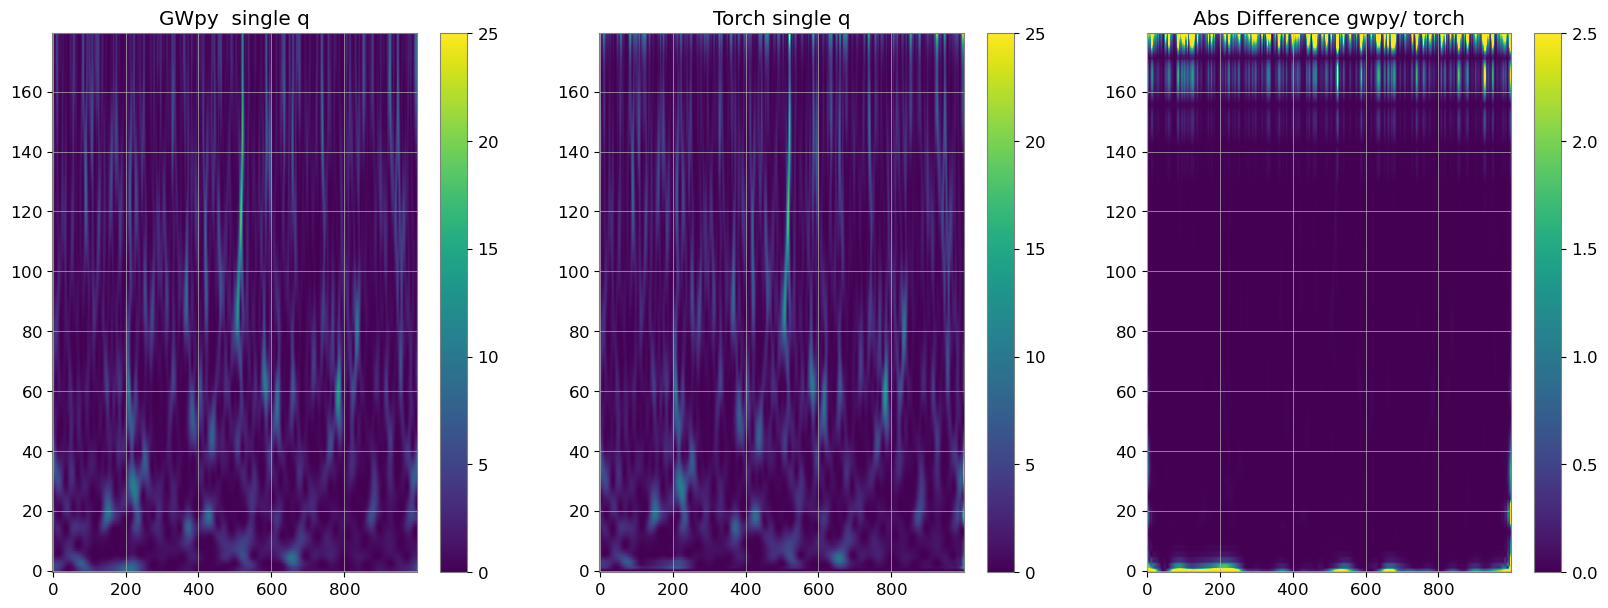

SIZE GWPY: (180, 1000)
SIZE TORCH: torch.Size([2, 180, 1000])
MAX VALUE OF GWPY: 19.921783447265625
MAX VALUE OF TORCH: 31.57733154296875
MEAN OF TORCH PLOT: 1.565354824066162; STD: 1.8113348484039307
MEAN OF GWPY PLOT: 1.544598937034607; STD: 1.7156884670257568
MEAN OF ABS DIFF PLOT: 0.1108936220407486; STD: 0.5539699792861938 
MAX OF ABS DIFF PLOT: 23.202180862426758
Total time: 1.3401026725769043s


In [27]:
#Compute Qtiles
start=time.time() 
gwpy_transform,transformed=compute_transforms(df,tensor, q=q, frange=frange, sample_rate=sample_rate, qrange=qrange, num_t_bins=num_t_bins, fres=fres,num_processes=1)
end=time.time()
print(f'Total time: {end-start}s')

## Test interpolation

In [ ]:
import importlib
import sys
from torch_spline_interpolation_beta import *

# Reload the module
importlib.reload(sys.modules['torch_spline_interpolation_beta'])

#### 1D

In [7]:
torch_qtransform=SplineInterpolate1D(num_t_bins)

print(tensor.shape)

xrow = torch.arange(0.0, (0.0 + duration), duration/tensor.shape[-1])
xout = torch.arange(0.0,0.0+duration , step=duration / num_t_bins)

Z_interp=torch_qtransform(Z=tensor, xin=None, xout=xout)

torch.Size([5, 3000])
Z.shape=torch.Size([5, 3000])
coef.shape=torch.Size([5, 3002])


In [8]:
print(Z_interp.shape)

torch.Size([5, 1000])


#### 2D

In [9]:
# Generate data
x = np.linspace(-1, 1, 30)
y = np.linspace(-1, 1, 40)
x_grid, y_grid = np.meshgrid(x, y)
z = (x_grid + y_grid) * np.exp(-6.0 * (x_grid ** 2 + y_grid ** 2))

# Convert data to torch tensors
Z = torch.tensor(np.stack([z] * 5, axis=0), dtype=torch.float32)  # Batch of 5 identical images

print(f'{Z.shape=}')

model = SplineInterpolate2D(num_t_bins=150, num_f_bins=150)

# Perform interpolation
Z_interp = model(Z)

print(Z_interp.shape)  # Output shape should be (batch_size, 150, 150)

Z.shape=torch.Size([5, 40, 30])
Z.shape=torch.Size([5, 40, 30])
Bx.shape=torch.Size([1, 42, 150])
By.shape=torch.Size([1, 150, 32])
C.shape=torch.Size([5, 32, 42])
torch.Size([5, 150, 150])


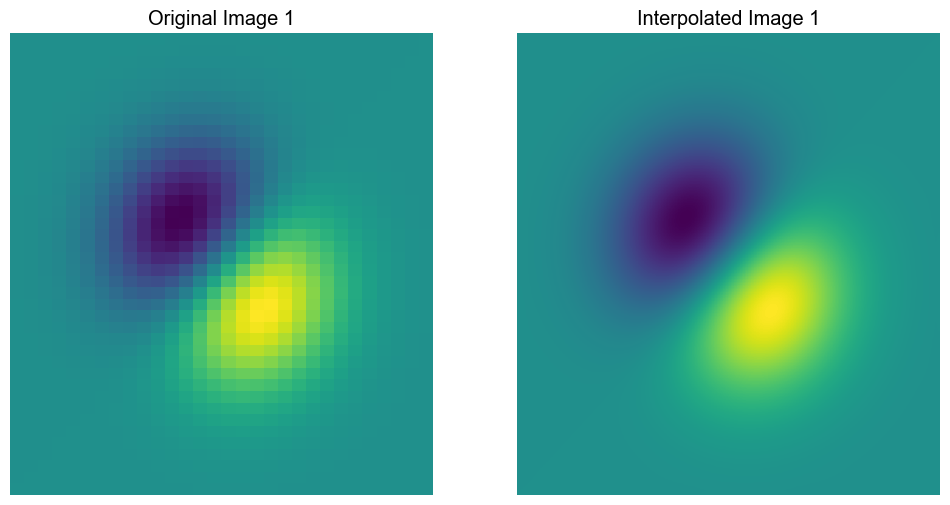

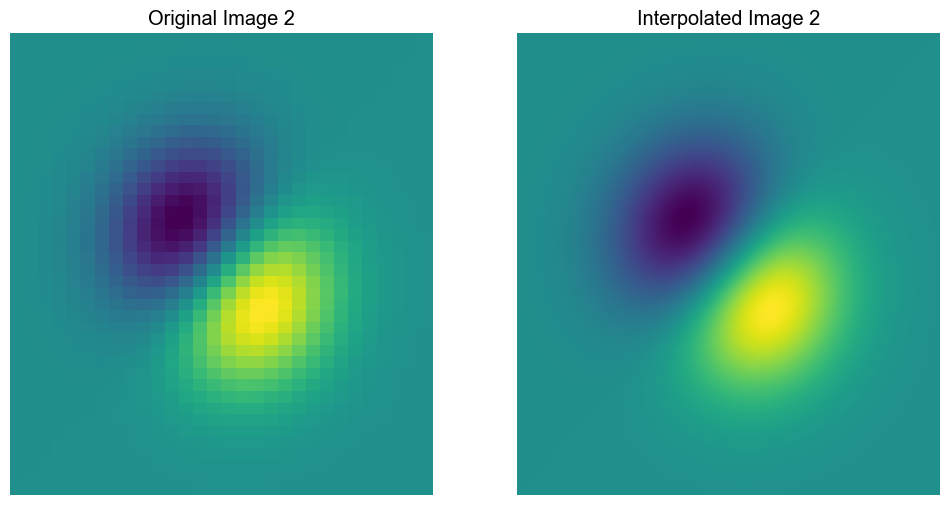

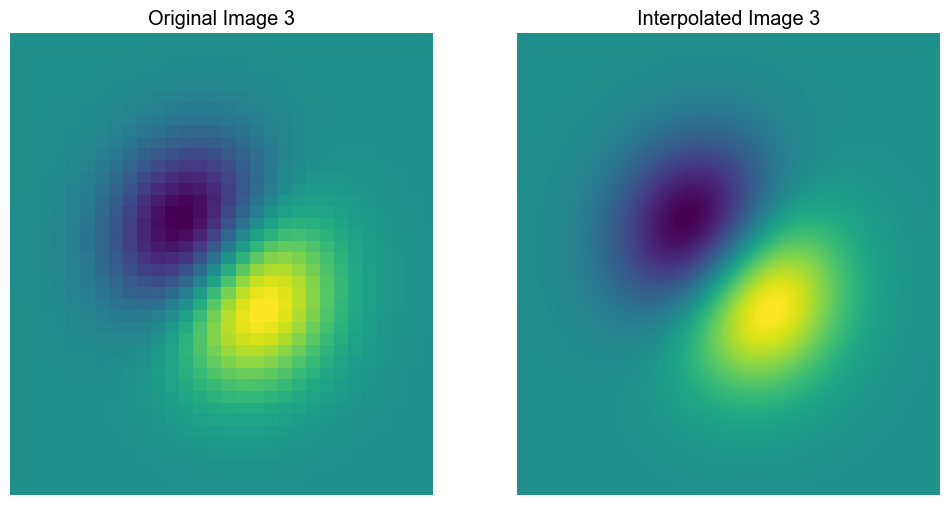

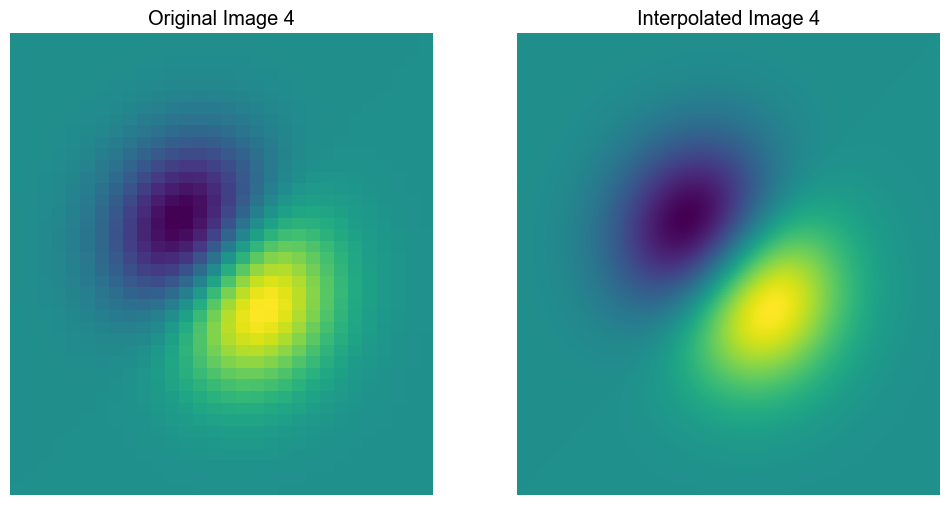

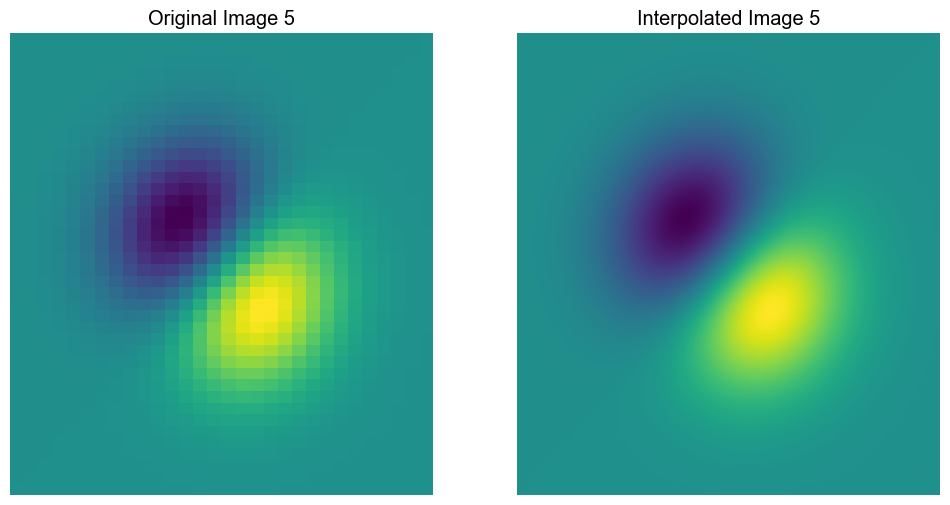

In [10]:
import matplotlib.pyplot as plt

def plot_original_vs_interpolated(Z_original, Z_interpolated, num_samples_to_plot=5):
    """
    Plots the original 2D images versus the interpolated ones.

    Args:
        Z_original: Original 3D tensor of shape (batch_size, height, width).
        Z_interpolated: Interpolated 3D tensor of shape (batch_size, new_height, new_width).
        num_samples_to_plot: Number of samples to plot from the batch.
    """
    batch_size = Z_original.shape[0]
    num_samples_to_plot = min(batch_size, num_samples_to_plot)
    
    for i in range(num_samples_to_plot):
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
        # Plot original image
        axes[0].imshow(Z_original[i].cpu().numpy(), aspect='auto', cmap='viridis')
        axes[0].set_title(f'Original Image {i+1}')
        axes[0].axis('off')
        
        # Plot interpolated image
        axes[1].imshow(Z_interpolated[i].cpu().numpy(), aspect='auto', cmap='viridis')
        axes[1].set_title(f'Interpolated Image {i+1}')
        axes[1].axis('off')
        
        plt.show()

plot_original_vs_interpolated(Z, Z_interp, num_samples_to_plot=5)
